In [3]:
import os
import csv
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from p7modules.barmesh.basicgeo import P2, P3

In [16]:
thickness = 10
geom = "geo"
"# Shell elements detected, thickness {}mm on item {}\n".format(thickness, geom)

'# Shell elements detected, thickness 10mm on item geo\n'

In [9]:
def readfile2vecs(fname, scale = 1):
    '''Opens an xyz csv file (fname) and reads in as a list of vectors for each section'''
    k = list(csv.reader(open(fname)))
    wingmeshuvudivisions = eval(k[0][-3])
    assert (wingmeshuvudivisions == len(k[0])/3-1), 'Section numbering incorrect'
    vecs = []
    for i in range(0, (wingmeshuvudivisions*3)+2, 3):
        sec = []
        for j in range(2, len(k)):
            sec.append(P3(float(k[j][i])*scale, float(k[j][i+1])*scale, float(k[j][i+2])*scale))
        vecs.append(sec)
    return vecs

def findLEind(sec):
    '''Find the index position of the LE highlight for a section'''
    LEind = False
    for i in range(1,len(sec)):
        if not LEind and sec[i].x>sec[i-1].x:
            LEind = i-1
            break
    return LEind

In [8]:
scale =1
folder = '/home/timbo/myrepos/gitlab/wildcat/Raw Geometry/'
fname = folder+"P7Wildcat-240924.csv"


In [14]:
wingletInd = 26
surf = readfile2vecs(fname,scale)
surf = surf[wingletInd:]
LEindRef = findLEind(surf[0])
for sec in surf:
    LEind = findLEind(sec)
    print(LEind)

30
31
31
31
31


In [4]:
from xfoil import XFoil
xf = XFoil()
from xfoil.test import naca0012
xf.airfoil = naca0012

In [5]:
xf.Re = 1e6
xf.max_iter = 40
a, cl, cd, cm, cp = xf.aseq(-20, 20, 0.5)

 Calculating unit vorticity distributions ...
 Calculating wake trajectory ...
 Calculating source influence matrix ...

 Solving BL system ...

 Initializing BL ...
    side            1  ...
 MRCHUE: Inverse mode at  57     Hk =   3.800
 MRCHUE: Inverse mode at  58     Hk =   4.251
    side            2  ...
 MRCHUE: Inverse mode at  30     Hk =   4.677
 MRCHUE: Inverse mode at  31     Hk =   6.225
 MRCHUE: Inverse mode at  32     Hk =   7.762
 MRCHUE: Inverse mode at  33     Hk =   9.325
 MRCHUE: Inverse mode at  34     Hk =   4.864
 MRCHUE: Inverse mode at  35     Hk =   2.500
 MRCHUE: Inverse mode at  55     Hk =   2.500
 MRCHUE: Inverse mode at  56     Hk =   2.500
 MRCHUE: Inverse mode at  57     Hk =   2.500
 MRCHUE: Inverse mode at  58     Hk =   2.500
 MRCHUE: Inverse mode at  59     Hk =   2.500
 MRCHUE: Inverse mode at  60     Hk =   2.500
 MRCHUE: Inverse mode at  61     Hk =   2.500
 MRCHUE: Inverse mode at  62     Hk =   2.500
 MRCHUE: Inverse mode at  63     Hk =   2.50

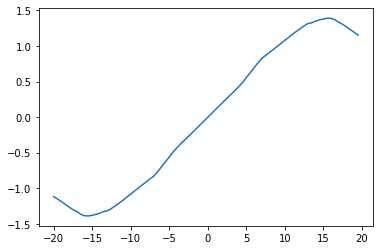

In [6]:
import matplotlib.pyplot as plt

plt.plot(a, cl)
plt.show()

In [194]:
def interpolate_section(r,secpts,rs):
    assert len(secpts) == len(rs), 'Must a position for every section'
    for pts in secpts:
        assert len(pts) == len(secpts[0]), 'sections must contain same number of points'
    OPpts = []
    for i in range(len(secpts[0])):
        ys = []
        for j in range(len(secpts)):
            assert secpts[j][i][0] == secpts[0][i][0], 'sections must have matching x ordinates'
            ys.append(secpts[j][i][1])
        y = np.interp(r, rs, ys)
        OPpts.append((secpts[0][i][0], y, 0))
    return OPpts

def convertDS(pts,ds, LEr ,chord):
    l=len(pts)
    aerof=[]
    dsp = [ds,0]
    dsfp = [LEr,0]
    found = False
    front = False
    pl = pts[0]
    highlight=False

    for p in pts:
        x = p[0]*chord
        if ds >= chord:
            dsp[1] = 0
            found = True
        elif p[0]*chord < ds and not found:
            dsp[1] = p[1]*chord + ((ds-p[0]*chord)*(pl[1]-p[1]))/(pl[0]-p[0])
            found = True
            print(dsp)
            
        if not highlight and p[0]>pl[0]:
            highlight = True
            print('found highlight',pl)
        
        #Correction for following round tube diameter
        if highlight and x < LEr:
            
            z = -np.sqrt(r**2 - (x-r)**2)
            print('x=', x, 'z=',z)
        else: 
            z = p[1]*chord
        if highlight and x > LEr:
            #dsfp[1]= p[1]*chord + ((LEr-p[0]*chord)*(pl[1]-p[1]))/(pl[0]-p[0])
            dsfp[1] = -r 
            print('LEr',x)
            print(dsp)
            BSptsx=np.linspace(x,dsp[0],l-len(aerof))
            for x in BSptsx:
                z=np.interp(x,[dsfp[0],dsp[0]],[dsfp[1],dsp[1]])
                #aerof.append(App.Vector(0,-x,z))
                aerof.append((0,-x,z))
            break
        #aerof.append(App.Vector(0,-p[0]*chord,p[1]*chord))
        aerof.append((0,-x,z))
        pl = p
    return aerof,dsp

In [195]:

root_file = '../data/aerofoils/ui1720reflex.csv'
mid_file = '../data/aerofoils/2R15section.csv'
outb_file = '../data/aerofoils/2R15section.csv'
tip_file = '../data/aerofoils/tipsection.csv'
rootpts = np.loadtxt(root_file,delimiter = ',')
midpts = np.loadtxt(mid_file,delimiter = ',')
outbpts = np.loadtxt(outb_file,delimiter = ',')
tippts = np.loadtxt(tip_file,delimiter = ',')
secpts = [rootpts,midpts,outbpts,tippts]
rs = [0,0.5,0.75,1]
secs = [0.0, 512.82, 1229.5, 1957.07, 2723.31, 3355.0, 3991.88, 4417.58]
chords = [2258.95895423, 2033.6988477700002, 1782.04461041, 1601.0909708800002, 1385.6365501, 1171.991467860766, 789.7256825227719, 379.2314459999998]
seamDSs = [40,60,100,100,100,100,100,100]
doubleSurfs = [1639.058228, 1491.8569677278858, 1299.542453565293, 1177.4288350090994, 1131.1905556399997, 1051.991467860766, 669.7256825227719, 379.2314459999998]

In [203]:
s= 4
pts = interpolate_section(secs[s]/secs[-1],secpts,rs)
points, dsp = convertDS(pts, doubleSurfs[s], 26, chords[s])
dsp

[1131.1905556399997, 31.66695957989004]
found highlight (0.0, 0.0, 0)
x= 0.8881930286141 z= -6.7377407661511075
x= 5.1878232435744 z= -15.58375111002797
x= 12.909975737281702 z= -22.464444457886028
x= 23.3507471422852 z= -25.864675897754644
LEr 36.2427096044156
[1131.1905556399997, 31.66695957989004]


[1131.1905556399997, 31.66695957989004]

In [204]:
r = 26
x0,y0 = -r, 0
xcircs,ycircs = [],[]
for a in range(0,370,10):
    xcircs.append(x0 + r * np.cos(np.radians(a)))
    ycircs.append(y0 + r * np.sin(np.radians(a)))

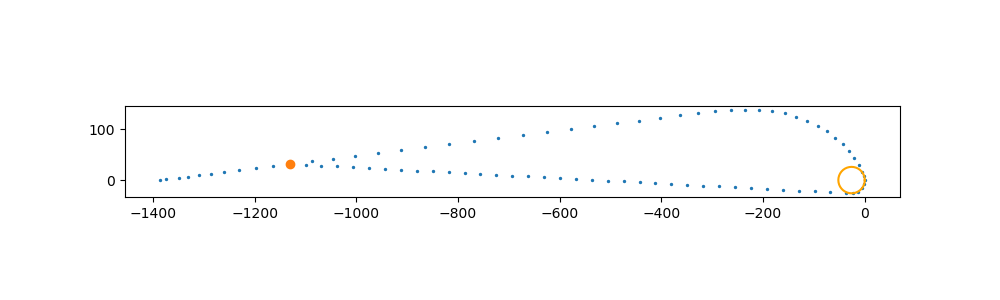

In [205]:
xs, ys = [],[]
for pt in points:
    xs.append(pt[1])
    ys.append(pt[2])

fig =plt.figure(figsize = (10,3))
plt.gca().set_aspect("equal")
plt.plot(xcircs,ycircs, color = 'orange')
plt.scatter(xs,ys, s=2)
plt.scatter(-dsp[0], dsp[1])
plt.show()

In [97]:
points

[(0, -2258.9566952710456, 0.008073765692662438),
 (0, -2239.0552668842793, -0.1028949310628745),
 (0, -2197.987393096378, -0.6192380608537426),
 (0, -2169.5086975604004, -1.023515282546475),
 (0, -2135.856986019236, -1.2656357693585791),
 (0, -2097.185867681773, -1.665366442494607),
 (0, -2053.6308800852644, -1.1592147131081432),
 (0, -2005.445026632584, -0.8325639267284122),
 (0, -1952.799988204254, 0.6521354007652256),
 (0, -1896.0052421770033, 2.9355332812699464),
 (0, -1835.3228277895228, 6.799201472495554),
 (0, -1771.0961068028553, 12.770703294286536),
 (0, -1703.6594051422273, 20.581987803323603),
 (0, -1633.4193354193994, 29.786960384951215),
 (0, -1560.703446682736, 40.09921057032775),
 (0, -1485.9838613536701, 51.57044443933721),
 (0, -1409.622012864879, 64.14363025925365),
 (0, -1332.1148721862937, 77.69339211138731),
 (0, -1253.8667929707208, 92.08868935218199),
 (0, -1175.34763868064, 107.156689077857),
 (0, -1097.0114600658521, 122.55840703855509),
 (0, -1019.337156424653